<a href="https://colab.research.google.com/github/aquapathos/openCVLesson/blob/master/Errordiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 誤差拡散法の比較

# 1.  画像のアップロードと読み込み
## 処理対象画像についての注意

- 注意事項１を念頭に入れて、対象画像を選ぶこと。
 
- 下のプログラムでは、実験条件を均一にするために、処理対象画像の中央を正方形にクリッピングし、256x256のサイズにリサイズする。それを念頭に入れて画像を選ぶこと。観察したい部分が上下左右にずれているなら、それが中央に来るように自分で切り抜いた画像をアップせよ。
 
-  カラー画像を対象としたディザ変換、誤差拡散も可能であるが、ここではグレイ画像を実験対象としている。読み込み時にグレイで読み込むので、事前にグレイ画像に変換する必要はない。
 

Saving ai_model_09.png to ai_model_09 (5).png


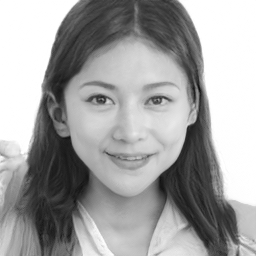

図１. 処理対象画像（グレイ変換と２５６x２５６サイズにリサイズ済


In [1]:
import cv2
from google.colab import files
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import widgets

filename = list(files.upload())[0]
img = cv2.imread(filename,0) # グレイで読み込み
(height,width) = img.shape[:2]
size = height if height < width else width
img = img[(height-size)//2:(height-size)//2+size,(width-size)//2:(width-size)//2+size]
img = cv2.resize(img,(256,256))
cv2_imshow(img)
print("図１. 処理対象画像（グレイ変換と２５６x２５６サイズにリサイズ済")

# ２. 単純な２階調化

比較のために、単純な２階調化結果を示しておく。ここでは大津の方法（判別分析法）を用いてしきい値を決定した。

ディザ変換も誤差拡散法も結果画像は２値画像であるということに注意されたい。

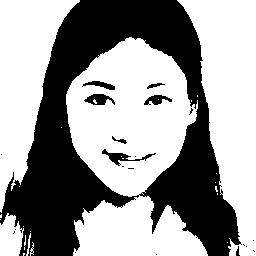

図２.  単純な２階調化結果（しきい値=147.0）


In [2]:
thres, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
cv2_imshow(otsu)
print("図２.  単純な２階調化結果（しきい値={}）".format(thres))

# 3.  誤差拡散法１　単純右送り
座標(i,j)の画素値（明るさ）を gray[i][j] とする。

判別分析法によるしきい値を基準として、それより大きければ白（255）、小さければ黒（0）とする。
量子化誤差を err とすると、

- 白の場合は err = gray[i][j] -255
- 黒の場合は err = gray[i][0]

の誤差が発生する。

左上から１画素ずつ２値化の処理を施していきながら、発生した誤差を次に処理する画素の画素値に上乗せする。

これにより、画像全体の画素値の合計は処理前と処理後でほぼ等しくなる。


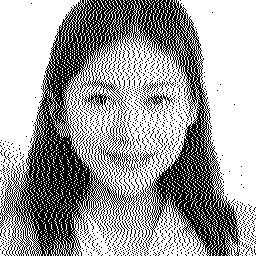

図3.  単純右送りの誤差拡散法の結果


In [3]:
gray = img.copy()

thresh = 128 # 閾値
err = 0 # 誤差
 
for i in range(256):
	for j in range(256):
		if gray[i][j] + err < thres:
			err = gray[i][j] + err - 0 # 誤差を計算
			gray[i][j] = 0
		else:
			err = gray[i][j] + err - 255 # 誤差を計算
			gray[i][j] = 255
            
cv2_imshow(gray)
print("図3.  単純右送りの誤差拡散法の結果")

# 4. 誤差拡散法２　４画素への誤差拡散

教科書にあるように、右隣りと下隣りの画素へ誤差の 5/16ずつ 、左下と右下の斜め隣りの画素へ誤差の3/16ずつの量を拡散する。

一番右端と最下行は例外処理しないといけない。一番下以外の右端では左下隣の画素に 3/8、真下の画素に 5/8拡散。一番下の行だけは単純右送り。

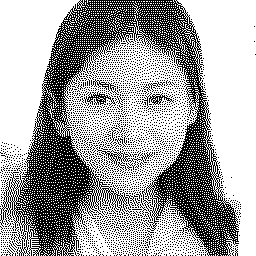

図４.  隣接４画素への誤差拡散の結果


In [4]:
gray = img.copy().astype(np.float32)

thresh = 128 # 閾値
err = 0 # 誤差
 
for i in range(256):
	for j in range(256):
            if gray[i][j]< thresh:
                err = gray[i][j] # 誤差を計算
                gray[i][j] = 0
            else:
                err = gray[i][j] - 255 # 誤差を計算
                gray[i][j] = 255
                        
            if i < 255 : 
                if  j < 255:
                    gray[i][j+1] += (5.0/16)*err        #  右
                    gray[i+1][j -1] += (3.0/16)*err   #  左下
                    gray[i+1][j] += (5.0/16)*err        #  下
                    gray[i+1][j +1] += (3.0/16)*err  #  右下 
                else:   # 右端で一番下の行以外
                    gray[i+1][j-1] += (5.0/8)*err    #   左下
                    gray[i+1][j] += (5.0/8)*err        #  下
            elif  j != 255 : # 一番下の行の場合は右奥りのみ 
                gray[i][j+1] += err
            
cv2_imshow(gray)
print("図４.  隣接４画素への誤差拡散の結果")